# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [227]:
reset 

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [228]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [229]:
flight_delay = pd.read_csv("flight_information.csv")

In [386]:
# Cleaning things: flights should take longer than 0 minutes, and get rid of extreme early outliers
flight_delay = flight_delay[flight_delay['air_time']>0]
#Don't consider diverted or cancelled flights
flight_delay.drop(flight_delay[(flight_delay['cancelled']==1) | (flight_delay['diverted']==1)].index, inplace=True)


In [387]:
model_df = flight_delay[['fl_date', 'mkt_unique_carrier', 'origin', 'dest', 'arr_delay']]
model_df = model_df[model_df['arr_delay']>-60]


model_df = model_df.fillna(0)

In [232]:
model_df

,fl_date,mkt_unique_carrier,origin,dest,arr_delay
0,2018-07-25,B6,HPN,MCO,45.0
1,2019-02-16,UA,DFW,ORD,7.0
2,2019-02-28,DL,ORD,ATL,-29.0
3,2018-10-28,AA,HHH,CLT,-2.0
4,2018-04-27,WN,STL,HOU,-15.0
...,...,...,...,...,...
199995,2019-05-18,AA,LAS,LAX,23.0
199996,2019-06-24,AS,SLC,SFO,-7.0
199997,2019-01-13,NK,SAN,IAH,-14.0
199998,2019-04-08,UA,SFO,SLC,-8.0


In [388]:
# Extract month from the flight dates (use it in our model)
model_df['month'] = pd.DatetimeIndex(model_df['fl_date']).month
model_df = model_df.drop(columns=['fl_date'])

# and make ready for categorical
model_df['month'] = model_df['month'].replace({1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
                            5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"})


# Get rid of negatives; early flights are weird (remember, "where" replaces conditions that are false)
model_df['arr_delay'] = model_df['arr_delay'].where(model_df['arr_delay'] > 0, 0)

y_clas = model_df[['arr_delay']]# save this for Random Forest Classifier

In [234]:
# model_df

In [333]:
# Extract target variable
y = np.array(model_df['arr_delay'])
# y_clas = y # save this for Random Forest ClassifierNDSU football
model_df = model_df.drop(columns=['arr_delay'])

# ...and features
X = pd.get_dummies(model_df)
X_columns = X.columns

In [236]:
# y.max()

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [237]:
#Try Sparse PCA, since this is sparse data...
from sklearn.decomposition import MiniBatchSparsePCA

In [238]:
from sklearn.model_selection import train_test_split
# y = np.log10(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [239]:
pca_trans = MiniBatchSparsePCA(n_components=5, batch_size=30, random_state=0)
pca_trans.fit(x_train)

MiniBatchSparsePCA(batch_size=30, n_components=5, random_state=0)

In [240]:
x = pca_trans.transform(X)

In [241]:
# x_transformed.shape

In [242]:
# x.shape

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

#### Random Forest Regressor

In [243]:
from sklearn.model_selection import train_test_split
# y = np.log10(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [244]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=5)
rfr.fit(x_train, y_train)
y_train_pred = rfr.predict(x_test)

In [245]:
feature_val = rfr.feature_importances_
# print(type(feature_val))
X_columns = range(5)  ### if using MiniBatchSparsePCA, use this
feature_name = X_columns
# print(feature_name)

features = pd.DataFrame({"Feature names": pd.Series(dtype='str'),
                         "Importance": pd.Series(dtype='int')})
features['Feature names'] = feature_name
features['Importance'] = feature_val
# print(features.shape)
# features = features.rename(columns={0: "name", 1: "vale"})
# features.sort_values(by=["vale"], ascending=False)
features.sort_values(by=['Importance'], ascending=False).head(20)

,Feature names,Importance
0,0,0.226268
2,2,0.213065
3,3,0.197161
4,4,0.195816
1,1,0.167690


In [246]:
from sklearn.metrics import r2_score
r2_score(y_test, y_train_pred)

-0.01650110355890444

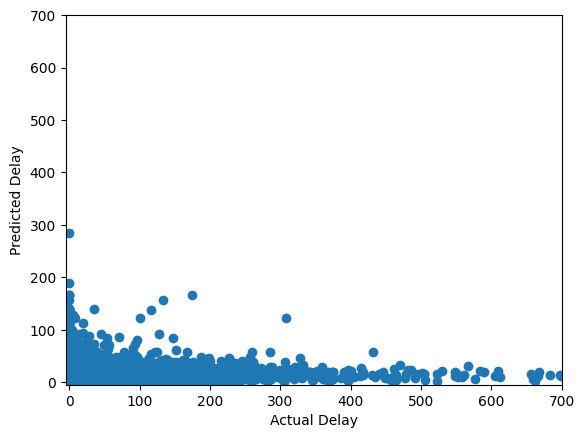

In [247]:
plt.scatter(y_test, y_train_pred)
plt.xlabel("Actual Delay")
plt.ylabel("Predicted Delay")
plt.xlim(-5, 700 )
plt.ylim(-5, 700)
plt.show()

#### random forest classifiers 

In [248]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, classification_report 


For delays, we're going to try to classify the delays as the following: 

- no delays (<15 mins)
- minor delays (15-30 minutes)
- longer delays (30-60)
- loooong delays (>60 mins)

As we see below, each delay represents certain percentiles

In [389]:
# Create labels for data (Rather than treat it as continuous)

y_clas.loc[( (y_clas['arr_delay']  >= 0) & (y_clas['arr_delay'] <15)), 'arr_delay'] = 0
y_clas.loc[(y_clas['arr_delay']  >= 15), 'arr_delay'] = 1

y_clas = np.array(y_clas)


/tmp/ipykernel_4068/1094801451.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_clas.loc[( (y_clas['arr_delay']  >= 0) & (y_clas['arr_delay'] <15)), 'arr_delay'] = 0
/tmp/ipykernel_4068/1094801451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_clas.loc[(y_clas['arr_delay']  >= 15), 'arr_delay'] = 1


In [390]:
# y_clas.max()

In [391]:

# labels = list(range(3))
# y_clas = pd.qcut(y_clas, 3, labels, .sort_values()duplicates='drop')
x_train, x_test, y_train, y_test = train_test_split(x, y_clas, test_size = 0.3)

In [392]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, class_weight = 'balanced') # class_weights gives higher weight to our small number of delays
rfc.fit(x_train, y_train)
y_train_pred = rfc.predict(x_test)

/tmp/ipykernel_4068/2731765193.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train, y_train)


In [393]:
feature_val = rfc.feature_importances_
# print(type(feature_val))
X_columns = range(5)  ### if using MiniBatchSparsePCA, use this
feature_name = X_columns
# print(feature_name)

features = pd.DataFrame({"Feature names": pd.Series(dtype='str'),
                         "Importance": pd.Series(dtype='int')})
features['Feature names'] = feature_name
features['Importance'] = feature_val
# print(features.shape)
# features = features.rename(columns={0: "name", 1: "vale"})
# features.sort_values(by=["vale"], ascending=False)
features.sort_values(by=['Importance'], ascending=False).head(20)

,Feature names,Importance
4,4,0.222716
2,2,0.202757
0,0,0.195210
3,3,0.194720
1,1,0.184597


In [394]:
accuracy_score(y_test, y_train_pred)

0.552937448930245

In [395]:
print(classification_report(y_test, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.56      0.67     48493
         1.0       0.22      0.54      0.31     11474

    accuracy                           0.55     59967
   macro avg       0.53      0.55      0.49     59967
weighted avg       0.72      0.55      0.60     59967



In [396]:
print(confusion_matrix(y_test, y_train_pred))

[[27000 21493]
 [ 5316  6158]]


#### Naive Bayes

In [397]:
from sklearn.naive_bayes import GaussianNB

In [398]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

/home/marcjb/anaconda3/envs/lhl_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [399]:
y_pred = gnb.predict(x_test)

In [400]:
accuracy_score(y_test, y_pred)

0.8086614304534161

In [401]:
print(confusion_matrix(y_test, y_pred))

[[48493     0]
 [11474     0]]


### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.